## Vehicle Detection

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Load Training Images

In [1]:
import glob
import os
import sys

def get_img_path_in_folder(path_folder):
    full_path = path_folder + '/**/*.png'
    img_path_list = []

    for filename in glob.iglob(full_path, recursive=True):
        img_path_list.append(filename)

    return img_path_list

data_folder = './data'
vehicles_folder = data_folder + '/vehicles'
non_vehicles_folder = data_folder + '/non-vehicles'

print(vehicles_folder)
print(non_vehicles_folder)

vehicle_img_path = get_img_path_in_folder(vehicles_folder)
non_vehicle_img_path = get_img_path_in_folder(non_vehicles_folder)
print(len(vehicle_img_path))
print(len(non_vehicle_img_path))

./data/vehicles
./data/non-vehicles
8792
8968


## Extract Features

In [2]:
from skimage.feature import hog
import numpy as np
import cv2

class Feature_extractor():
    def __init__(self, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
        self.spatial_feat = spatial_feat
        self.hist_feat = hist_feat
        self.hog_feat = hog_feat
        self.a = 10
        pass
    
    def extract(self, img):
        
        color_space = self.color_space
        spatial_size = self.spatial_size
        hist_bins = self.hist_bins
        orient = self.orient
        pix_per_cell = self.pix_per_cell
        cell_per_block = self.cell_per_block
        hog_channel = self.hog_channel
        spatial_feat = self.spatial_feat
        hist_feat = self.hist_feat
        hog_feat = self.hog_feat
        
        #1) Define an empty list to receive features
        img_features = []
        
        #2) Apply color conversion if other than 'RGB'
        feature_image = self.transform_color(img, color_space)
        
        #3) Compute spatial features if flag is set
        if spatial_feat == True:
            spatial_features = self.bin_spatial(feature_image, size=spatial_size)
            #4) Append features to list
            img_features.append(spatial_features)
            
        #5) Compute histogram features if flag is set
        if hist_feat == True:
            hist_features = self.color_hist(feature_image, nbins=hist_bins)
            #6) Append features to list
            img_features.append(hist_features)
        
        #7) Compute HOG features if flag is set
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(self.get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))      
            else:
                hog_features = self.get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            #8) Append features to list
            img_features.append(hog_features)
        
        
        #9) Return concatenated array of features
        return np.concatenate(img_features)
    
    def transform_color(self, img, color_space='RGB'):
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)
        return feature_image
    
    # Define a function to compute binned color features  
    def bin_spatial(self, img, size=(32, 32)):
        # Use cv2.resize().ravel() to create the feature vector
        features = cv2.resize(img, size).ravel() 
        # Return the feature vector
        return features
    
    # Define a function to compute color histogram features 
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(self, img, nbins=32, bins_range=(0, 1)):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features
    
    def aux(self):
            print(self.a)

In [102]:
import numpy as np
from sklearn.utils import shuffle

def images_load_subset(images_path, subset):
    img_len = len(images_path)
    subset = np.clip(subset, 0, 1)
    new_len = img_len*subset
    new_len = int(round(new_len))
    return shuffle(images_path)[:new_len]


def extract_features(img_paths, extrator):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in img_paths:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        feature = extractor.extract(image)
        features.append(feature)
    return features

879
897
879
36.69 Seconds to extract HOG features...


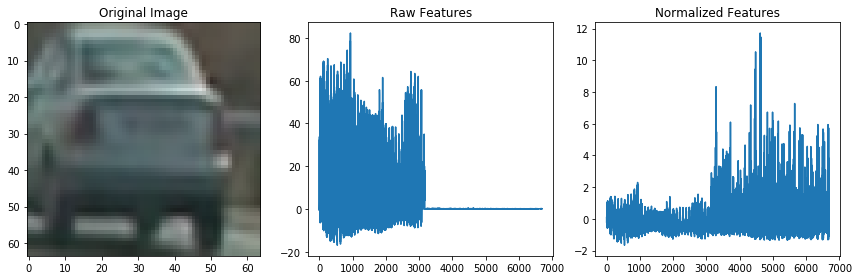

In [103]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from sklearn.preprocessing import StandardScaler

%matplotlib inline

new_vehicle_images_path = images_load_subset(vehicle_img_path, 0.1)
new_non_vehicle_images_path = images_load_subset(non_vehicle_img_path, 0.1)

print(len(new_vehicle_images_path))
print(len(new_non_vehicle_images_path))

test_image = mpimg.imread(vehicle_img_path[0])
#print(test_image)

colorspace = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 6
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"


extractor = Feature_extractor(color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t=time.time()
#car_features = extractor.extract(test_image)
len_car_images = len(new_vehicle_images_path)
car_features = extract_features(new_vehicle_images_path, extractor)
notcar_features = extract_features(new_non_vehicle_images_path, extractor)

a = len(car_features)
print(a)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

#X = np.vstack((car_features)).astype(np.float64)
#X_scaler = StandardScaler().fit(X)
#r = X_scaler.transform(np.array(car_features).reshape(1, -1))
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)
#print(X)
#plt.plot(r)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len_car_images)
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(new_vehicle_images_path[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## Build a Classifier

In [104]:
from sklearn.model_selection import train_test_split

y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))

Test Accuracy of SVC =  0.98595505618


## Window Creator

In [197]:
class Window_Creator:
    
    def __init__(self, window_size, overlap):
        self.window_size = window_size
        self.overlap = overlap
    
    def get_complex_windows(self, img):
        
        height = img.shape[0]
        y_start = 0.4*height
        y_start = int(round(y_start))
        new_y_start_stop = [y_start, None]
        
        overlap = (0.8, 0.8)
        sizes = []
        sizes.append((100, 100))
        sizes.append((200, 200))
        sizes.append((300, 300))
        
        windows = []
        for size in sizes:
            aux = self.slide_window(img, xy_window = size, xy_overlap = overlap, y_start_stop = new_y_start_stop)
            self.concatenate(windows, aux)
        
        
        test_window = ((807, 380),(950, 525))
        windows.append(test_window)

        return windows
        
    def concatenate(self, main_list, new_elements):
        for element in new_elements:
            main_list.append(element)
    
    def get_windows(self, img):
        windows = self.slide_window(img, xy_window = self.window_size, xy_overlap = self.overlap)
        return windows
    def slide_window(self, img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
     
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] == None:
            x_start_stop[0] = 0
        if x_start_stop[1] == None:
            x_start_stop[1] = img.shape[1]
        if y_start_stop[0] == None:
            y_start_stop[0] = 0
        if y_start_stop[1] == None:
            y_start_stop[1] = img.shape[0]
        # Compute the span of the region to be searched    
        xspan = x_start_stop[1] - x_start_stop[0]
        yspan = y_start_stop[1] - y_start_stop[0]
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
        ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
        nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
        ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
        # Initialize a list to append window positions to
        window_list = []
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
                # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
        # Return the list of windows
        return window_list
    
    def draw_windows(self, img):
        windows = self.get_complex_windows(img)
        return self.draw_boxes(img, windows)
        
    
    def draw_boxes(self, img, bboxes, color=(0, 0, 255), thick=6):
        # Make a copy of the image
        imcopy = np.copy(img)
        # Iterate through the bounding boxes
        for bbox in bboxes:
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        # Return the image copy with boxes drawn
        return imcopy


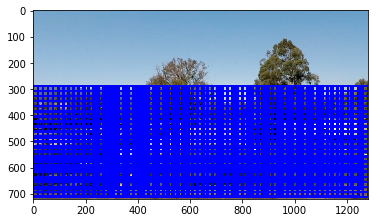

In [198]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

test_img_folder = './test_images/test4.jpg'
test_image = mpimg.imread(test_img_folder)

window_creator = Window_Creator(window_size = (128, 128), overlap = (0.1, 0.1))
image_with_window = window_creator.draw_windows(test_image)
plt.imshow(image_with_window)

## Vehicle Detector

In [199]:
class SimpleVehicleClassifier():
    def __init__(self, extractor, classifier, scaler):
        self.extractor = extractor
        self.classifier = classifier
        self.scaler = scaler
    def Is_Vehicle(self, img):
        features = self.extractor.extract(img)
        test_features = self.scaler.transform(np.array(features).reshape(1, -1))
        prediction = self.classifier.predict(test_features)
        if prediction == 1:
            return True
        else:
            return False

1.0
[[ 0.17254902  0.2         0.37254903 ...,  0.01176471  0.01568628
   0.01568628]
 [ 0.16470589  0.17254902  0.25490198 ...,  0.00392157  0.00392157
   0.00784314]
 [ 0.15686275  0.16078432  0.16862746 ...,  0.00392157  0.00392157
   0.02352941]
 ..., 
 [ 0.88235295  0.99607843  0.99607843 ...,  0.34901962  0.35294119
   0.35686275]
 [ 0.43137255  0.64313728  0.87450981 ...,  0.34509805  0.34901962
   0.35686275]
 [ 0.42745098  0.41568628  0.41568628 ...,  0.34509805  0.34901962
   0.35294119]]
break
[[ 0.23137255  0.17647059  0.28235295 ...,  0.02745098  0.04313726
   0.05098039]
 [ 0.17647059  0.15294118  0.28235295 ...,  0.01960784  0.02352941
   0.02745098]
 [ 0.16470589  0.16078432  0.1882353  ...,  0.00784314  0.01568628
   0.01960784]
 ..., 
 [ 0.41960785  0.43529412  0.43529412 ...,  0.35294119  0.35686275
   0.36470589]
 [ 0.40000001  0.40784314  0.41568628 ...,  0.35294119  0.36078432
   0.36470589]
 [ 0.36862746  0.38039216  0.3882353  ...,  0.35686275  0.36078432
   0.3

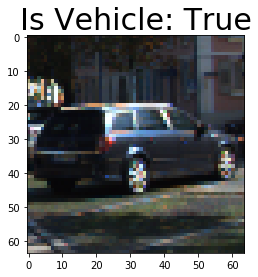

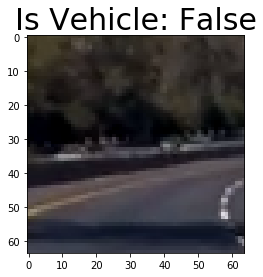

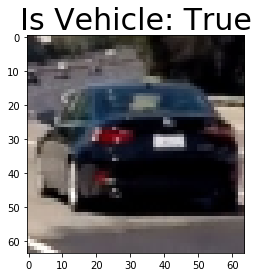

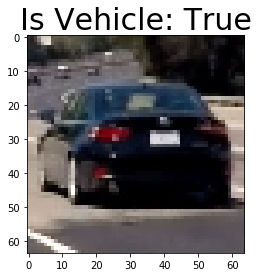

In [200]:
car_ind = np.random.randint(0, len(vehicle_img_path))
non_car_ind = np.random.randint(0, len(non_vehicle_img_path))

vehicle_img = mpimg.imread(vehicle_img_path[car_ind])
non_vehicle_img = mpimg.imread(non_vehicle_img_path[non_car_ind])

simpleClassifier = SimpleVehicleClassifier(extractor, svc, X_scaler)

print(np.amax(vehicle_img))
plt.figure(0)
plt.imshow(vehicle_img)
is_vehicle = simpleClassifier.Is_Vehicle(vehicle_img)
title = 'Is Vehicle: ' + str(is_vehicle)
plt.title(title, fontsize=30)

plt.figure(1)
plt.imshow(non_vehicle_img)
is_vehicle = simpleClassifier.Is_Vehicle(non_vehicle_img)
title = 'Is Vehicle: ' + str(is_vehicle)
plt.title(title, fontsize=30)

plt.figure(2)
vehicle_in_window = mpimg.imread('./test_images/vehicle_2.png')
plt.imshow(vehicle_in_window)
is_vehicle = simpleClassifier.Is_Vehicle(vehicle_in_window)
title = 'Is Vehicle: ' + str(is_vehicle)
plt.title(title, fontsize=30)

plt.figure(3)
crop_image = mpimg.imread('./test_images/test4.jpg')
window = ((807, 380),(950, 525))
crop_image = cv2.resize(crop_image[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
crop_image = crop_image/255.0
crop_image = crop_image.astype(np.float32)

plt.imshow(crop_image)
is_vehicle = simpleClassifier.Is_Vehicle(crop_image)
title = 'Is Vehicle: ' + str(is_vehicle)
plt.title(title, fontsize=30)

print(vehicle_in_window[:,:,0])
print("break")
print(crop_image[:,:,0])

In [201]:
class VehicleDetector():
    def __init__(self, simple_detector, window_creator):
        self.simple_detector = simple_detector
        self.window_creator = window_creator
    def detect(self, img):
        windows = self.get_windows(img)
        max_value = np.amax(img)
        if (max_value > 1):
            img = img /255
            img = img.astype(np.float32)
        
        #print(np.amax(img))
        windows_with_vehicle = []
        count = 0
        for window in windows:
            test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
            #print(np.amax(test_img))
            #plt.figure(count)
            #plt.imshow(test_img)
            count = count + 1
            is_vehicle = self.simple_detector.Is_Vehicle(test_img)
            if (is_vehicle == True):
                print("Found!")
                windows_with_vehicle.append(window)
            
        print(count)
        return self.window_creator.draw_boxes(img, windows_with_vehicle)
    
    def get_windows(self, img):
        windows = []
        windows = self.window_creator.get_complex_windows(img)
        return windows
                
        

In [ ]:
test_image_path = './test_images/test4.jpg'
test_image = mpimg.imread(test_image_path)
window_creator.overlap = (0.1, 0.1)
window_creator.window_size = (200, 200)
vehicle_detector = VehicleDetector(simpleClassifier, window_creator)

result = vehicle_detector.detect(test_image)
image_with_window = window_creator.draw_windows(test_image)

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(image_with_window)
ax3.set_title('Windows', fontsize=30)
ax3.imshow(result)
ax3.set_title('Vehicle Detection Image', fontsize=30)

Found!
Found!
Found!
Found!
Found!
Found!
Found!
Found!
Found!
Found!
Found!
